# **<center>** DEEP LEARNING PROJECT
## **<center>** Giannelli Alessio , Imbonati Lorenzo , Valoti Davide

## Introduzione e Obiettivo

L'obiettivo del progetto è la definizione di modelli neurali per la classificazione di video relativi a comportamenti e azioni che ogni persona svolge quotidiamente. 
Si è utilizzato il dataset HMDB (Human Motion DataBase) che contiene 6849 clips estratte da diverse fonti come YouTube o Google Video suddivise in 51 categorie d'azioni, ognuna contenente un minimo di 101 video. Le 51 attività possono a loro volta essere suddivise in 5 macro-categorie quali: 
1. generiche azioni facciali, come ridere;
2. azioni facciali utilizzando oggetti, come mangiare;
3. generici movimenti con il corpo, come correre;
4. movimenti corporali con l'utilizzo di oggetti, come calciare una palla;
5. movimenti del corpo al fine di attuare interazioni con altre persone, come abbracciare.

## Analisi e Procedimento

Per quanto riguarda la qualità dei dati utilizzati, si tratta di un dataset di circa 2 GB di dimensioni, il quale deve però essere modificato per poter tradurre i video in frames. 
A seguito di diversi tentativi e prove, si è deciso di utilizzare solamente quelle categorie relative alla macro-categoria 3, ovvero i generici movimenti del corpo. Si tratta di ben 19 attività sulle 51 totali. 

Si è dovuto procedere con questa scelta soprattutto a causa dell'utilizzo elevato di RAM e alla grande difficoltà, dopo vari tentativi, di trovare una soluzione alternativa ottimale; si è infatti concordato in gruppo che era preferibile analizzare e classificare una singola macro-categoria di attività umane nel modo più accurato e preciso possibile, piuttosto che procedere con un'analisi totale riducendo però il numero di video per ogni categoria o il numero di frames estratti da ogni video.

Si possono quindi descrivere le 19 attività scelte per l'analisi, salvate nel dataset *gen_body*: cartwheel (fare la ruota), clap (applaudire), climb (arrampicarsi), climb_stairs (salire le scale), dive (immergersi), fall_floor (cadere a terra), flic_flac, handstand (verticale), jump (saltare), pullup (tirarsi su), pushup (piegamenti), run (correre), sit (sedersi), situp (fare gli addominali), somersault (capriola), stand (alzarsi), turn (girarsi), walk (camminare), wave (salutare).

## Importazione delle librerie necessarie


In [ ]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-req-build-8i145u0q
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-req-build-8i145u0q
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35706 sha256=0293ee9bcbb126af80bc6082ecc9f3d6ab94f6e49243fce13ba9499ff366f37f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8s9j2f1v/wheels/64/82/dd/3d7823b3bbbe1aca9b30f8cf0d6bb6c1b72ccd95e3360f8190
Successfully built pafy


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2105344/45929032 bytes (4.6%)5423104/45929032 bytes (11.8%)8044544/45929032 bytes (17.5%)10878976/45929032 bytes (23.7%)13533184/45929032 bytes (29.5%)16515072/45929032 bytes (36.0%)19013632/45929032 bytes (41.4%)21266432/45929032 bytes (46.3%)24240128/45929032 bytes (52.8%)27033600/45929032 bytes (58.9%)30089216/45929032 bytes (65.5%)32866304/45929032 bytes (71.6%)

Per poter accedere ai dati si è deciso di collegare la cartella Drive al file python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Si è deciso inoltre di salvare la sessione di modo da poter importare più velocemente i dati

In [ ]:
### METODO 1
#import dill
#dill.load_session('/content/drive/MyDrive/Codice e Dataset/dl_video_20frame_96_64_.db')

### METODO 2
#import pickle
#file = open('/content/drive/MyDrive/Codice e Dataset/dl_video_20frame_96_64_.db', 'wb')
#pickle.dump(features, file, protocol= 4)

Infine, per poter ottenere per ogni esecuzione gli stessi risultati, si è deciso di definire un seed costante per le librerie Numpy e Tensorflow

In [ ]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#1. Analisi dei dati 

Uno dei primi passaggi è sicuramente la visualizzazione dei dati per avere informazioni di base per quanto riguarda la struttura, permettendo così di definire le decisioni migliori da prendere per quanto riguarda i parametri.
Si è già parlato in precedenza delle caratteristiche del dataset, ma si possono fornire ora dettagli più precisi.
Si hanno 19 categorie di azioni umane e ognuna di essa contiene una media di 160 video per categoria.

Si è deciso di visualizzare per ogni categoria un frame appartenente a un video casuale e visualizzare allo stesso tempo l'etichetta ad esso associata. L'obiettivo finale è infatti riuscire a mostrare l'etichetta corretta associata a un nuovo video che non è stato utilizzato per definire il modello di rete neurale.

In [ ]:
## CALCOLARE LA MEDIA DI VIDEO PER CATEGORIA
all_classes_names = os.listdir('/content/drive/MyDrive/DS - Project Work/Deep Learning/Progetto/Codice e Dataset/gen_body')
#all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body') 
tot = 0
p = []
for cat in all_classes_names:
  video_files_names_list = os.listdir(f'/content/drive/MyDrive/DS - Project Work/Deep Learning/Progetto/Codice e Dataset/gen_body/' + cat)
  num = int(len(video_files_names_list))
  p.append(num)
  tot += num
print(tot)
print(p)
avg = tot / len(all_classes_names)
avg

3039
[548, 108, 142, 127, 103, 151, 265, 122, 150, 114, 108, 104, 164, 140, 232, 136, 107, 105, 113]


159.94736842105263

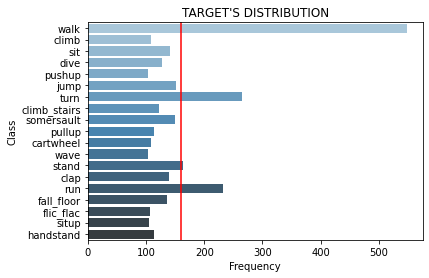

In [ ]:
import seaborn as sns
sns.barplot(y="Class", x="Frequency", data=dddd, palette="Blues_d").set(title="TARGET'S DISTRIBUTION")
plt.axvline(x = 159.94, color = 'r', label = 'mean')

plt.savefig('/content/drive/MyDrive/DS - Project Work/Deep Learning/Progetto/Codice e Dataset/tagets_distribution.eps', format='eps', dpi=1200, bbox_inches = 'tight')

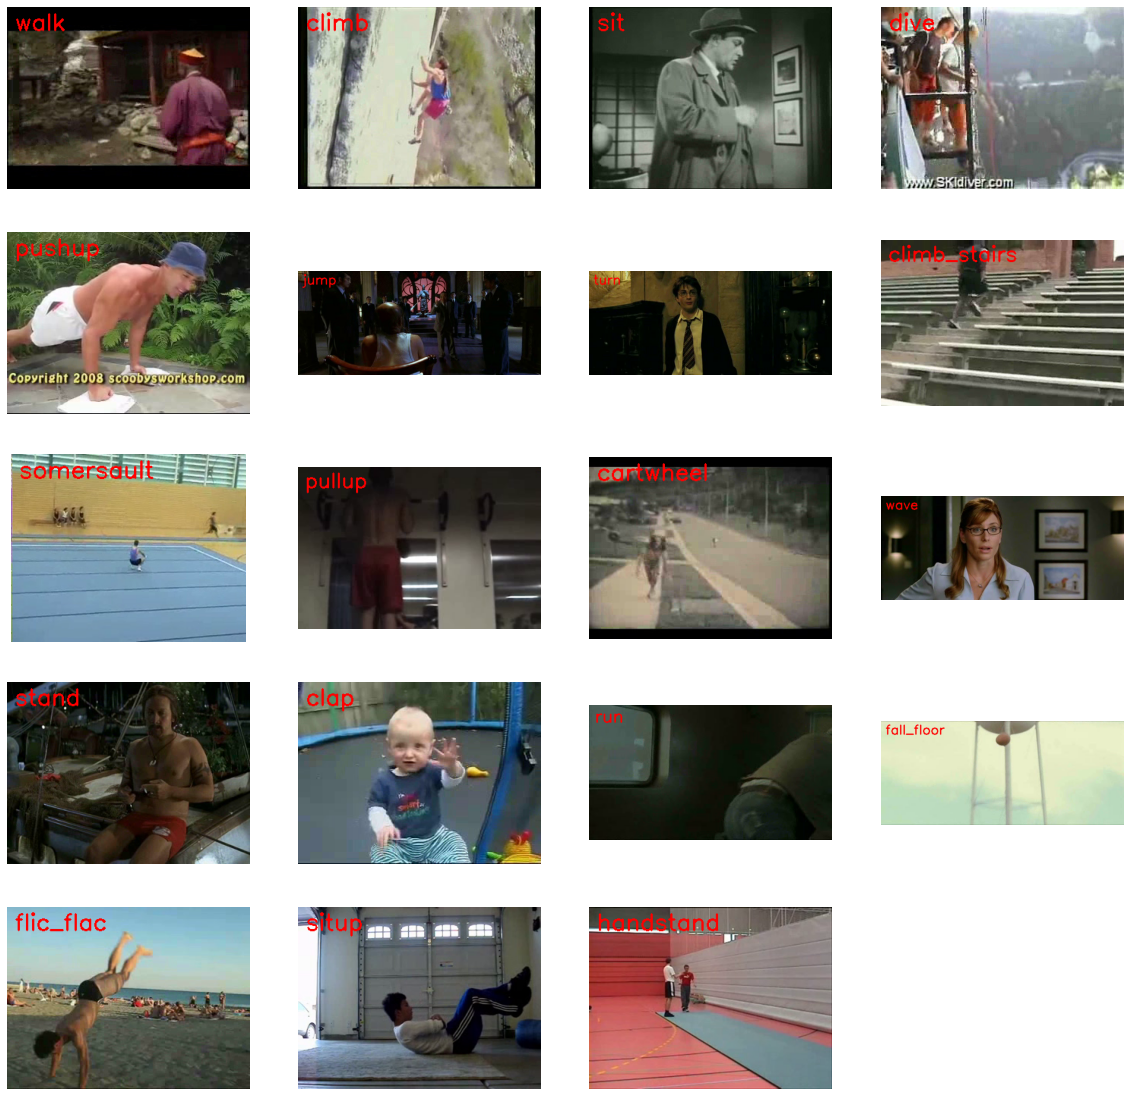

In [ ]:
## VISUALIZZAZIONE DEL PRIMO FRAME DI UN VIDEO CASUALE PER OGNUNA DELLE 19 CATEGORIE

# Si definisce la struttura che rappresenta il singolo frame
plt.figure(figsize = (20, 20))

# Si definisce la directory per estrarre i nomi delle categorie
all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body') 

# A questo punto si può definire un ciclo *for* per iterare rispetto alla lunghezza della lista delle categorie
# e definire così il valore *counter* per estrarre ogni singola categoria
for counter in range(len(all_classes_names)):

    # Si estrae una categoria in base al *counter*
    selected_class_Name = all_classes_names[counter]

    # Successivamente si estrae la lista di tutti i video della categora estratta precedentemente
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Codice e Dataset/gen_body/{selected_class_Name}')

    # A questo punto si può decidere di scegliere casualmente un video tra tutti quelli esistenti
    selected_video_file_name = random.choice(video_files_names_list)

    # Si utilizza una funzione della libreria cv2, ovvero VideoCapture, che permette di definire un elemento per la lettura di video
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Codice e Dataset/gen_body/{selected_class_Name}/{selected_video_file_name}')

    # Si può allora "leggere" il video ed estarre in questo caso solamente il primo frame
    _, bgr_frame = video_reader.read()

    # Una volta estatto il frame, è necessario rilasciare il VideoCapture per poterlo utilizzare con altri video
    video_reader.release()

    # Successivamente è necessario convertire il frame dal formato BGR a quello RGB per ottenere una visualizzazione dei colori corretta 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Passaggio fondamentale: la scrittura delle etichette su ogni immagine per identificare l'azione compiuta nel video
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Infine la visualizzazione delle diverse immagini 
    counter+=1
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 2. Preprocessing dei dati

Per poter lavorare con questa tipologia di dati è necessario effettuare alcune operazioni preliminari di pulizia, correzione e trasformazione. è infatti necessario normalizzare i frames estratti da ogni video, soprattutto per ridurre il costo computazionale. 

In [ ]:
## INIZIALIZZAZIONE DELLE COSTANTI PER DIMENSIONALITA' E NUMERO FRAMES PER VIDEO

# Si definisce innanzitutto la nuova dimensione sulla quale ridimensionare i frames
# Si è deciso di utilizzare questa per mantenere la forma rettangolare dei video e perché dimensioni maggiori non favorivano l'utilizzo di modelli troppo
# complessi a causa dell'utilizzo elevato di RAM
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 96

# Si definisce inoltre il numero di frames che si vogliono estrarre da ogni video, maggiore è il numero di frame maggiore sarà preciso il modello,
# ma allo stesso tempo aumenta il costo computazionale
SEQUENCE_LENGTH = 20

Tutti i parametri appena definiti possono essere incrementati per ottenere risultati migliori, allo stesso tempo si arriverà a una situazione di stallo nella quale non si potrà ottenere alcun miglioramento delle performance ma solamente un processo computazionalmente costoso.

In [ ]:
## DEFINIZIONE PERCORSO AL DATASET E LISTA CON I NOMI DELLE CATEGORIE

# Directory ai dati
DATASET_DIR = "/content/drive/MyDrive/Codice e Dataset/gen_body"

# Lista con i nomi delle categorie
all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body')
all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body')
CLASSES_LIST = all_classes_names

Il passaggio successivo è quello di creare una funzione che permetta di estrarre i frames dai video, ridimensionarli utilizzando i parametri appena definiti e normalizzarli in un range (0,1) dividendo ogni singolo pixel per il valore 255.

Si tratta di una funzione che presenta come unico argomento in input la directory al dataset con i video, e come output una lista che contiene i frames ridimensionati e normalizzati. Si sottolinea che la funzione appena citata verrà utilizzata all'interno della funzione successiva.

In [ ]:
def frames_extraction(video_path):

    # Si inizializza una lista vuota che conterrà i frames
    frames_list = []
    
    # Si riprende la funzione VideoCapture utilizzata precedentemente per "leggere" i video
    video_reader = cv2.VideoCapture(video_path)

    # A questo punto è necessario estrarre il numero totale di frame per video, questo perché 
    # si devono estrarre dei frame per tutta la lunghezza dei video e non solamente all'inizio
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # In questo modo infatti si suddivide il video in intervalli di frame uguali
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Si itera un ciclo for che andrà a scegliere 20 frames per video, li ridimensionerà e li normalizzerà singolarmente,
    # per poi aggiungerli alla lista inizializzata in precedenza
    for frame_counter in range(SEQUENCE_LENGTH):

        # In questo modo si selezionano in modo omogeneo i 20 frames sulla totalità del video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Si utilizza il comando per leggere i video
        # Si definisce inoltre anche l'elemento *success* perché l'elemento di lettura ha come output anche un valore booleano
        # che fornisce l'esito della procedura 
        success, frame = video_reader.read() 

        # Infatti in questo modo si verifica se la lettura è andata a buon fine
        if not success:
            break

        # Una volta estratti i frame, è necessario ridimensionarli con le dimensioni scelte autonomamente
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Infine si va a normalizzare ogni singolo frame dividendolo per 255 di modo che il valore di ogni singolo pixel sia compreso tra 0 e 1 
        normalized_frame = resized_frame / 255  
        
        # Dopo aver fatto tutte le procedure necessario per ottenere degli elementi di più facile lettura, analisi e comprensione,
        # è possibile aggiungerli alla lista dei frame che andrà a costituire l'elemento principale del dataset di partenza
        frames_list.append(normalized_frame)
    
    # Come detto in precedenza, dopo ogni lettura è necessario rilasciare l'elemento VideoCapture così che possa essere utilizzato su altri video 
    video_reader.release()

    # Essendo una funzione è necessario fornire un comando di return per quanto riguarda la lista dei frame
    return frames_list

### **<font style="color:rgb(134,19,348)">Funzione per la Creazione del Dataset</font>**


Si implementa la funzione create_dataset() che iterarà entro tutte le classi specificate nella costante CLASSES_LIST e chiamerà la funzione frame_extraction() su ogni file video delle classi selezionate per infine restituire i frame (features), l'indice di classe (labels) e il percorso del file video (video_files_paths).

In [ ]:
def create_dataset():

    # Dichiaro le liste in cui effetturò lo storage di feature, labels e filepath
    features = []
    labels = []
    video_files_paths = []
    
    # Iterazione entro tutte le classi della variabile CLASSES_LIST
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Lista dei video nella specifica classe
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterazione nella lista dei file della classe
        for file_name in files_list:
            
            # Estraggo il video path
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Estraggo i frame di ogni video con la funzione creata in precedenza
            frames = frames_extraction(video_file_path)

            # Verifico che i frame estratti di ogni video corrispondano alla variabile SEQUENCE_LENGHT
            if len(frames) == SEQUENCE_LENGTH:

                # Aggiungo alle rispettive liste gli elementi estratti
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Restituisco i frame, le classi, e i filepath
    return features, labels, video_files_paths
  

Si applica la funzione creata sopra salvando gli elementi lavorando con la CPU, molto più performante in questo tipo di operazioni.


In [ ]:
with tf.device('CPU:0'):
  features, labels, video_files_paths = create_dataset()

Extracting Data of Class: walk
Extracting Data of Class: climb
Extracting Data of Class: sit
Extracting Data of Class: dive
Extracting Data of Class: pushup
Extracting Data of Class: jump
Extracting Data of Class: turn
Extracting Data of Class: climb_stairs
Extracting Data of Class: somersault
Extracting Data of Class: pullup
Extracting Data of Class: cartwheel
Extracting Data of Class: wave
Extracting Data of Class: stand
Extracting Data of Class: clap
Extracting Data of Class: run
Extracting Data of Class: fall_floor
Extracting Data of Class: flic_flac
Extracting Data of Class: situp
Extracting Data of Class: handstand


Dopo aver creato gli elementi d'interesse, vengono risalvati in GPU, dato che nell'allenamento dei vari modelli risulta essere la più performante.

In [ ]:
with tf.device('GPU:0'):
  features = features*1
  labels = labels*1
  video_files_paths = video_files_paths*1

Una volta implementata e applicata la funzione, è necessario trasformare l'elemento features da lista ad array con dimensionialità (numero video, numero frame, dimensioni).

In [ ]:
features = np.asarray(features)

Si mostra anche la dimensionalità dell'elemento features creato.

In [ ]:
features.shape, features.size

((3038, 20, 96, 64, 3), 1119928320)

Stesso procedimento per labels, ovvero le etichette, salvate in un vettore di lunghezza pari al numero di video presenti.

In [ ]:
labels = np.array(labels)

Infine, è necessario creare una matrice delle etichette tramite conversione one_hot_encoded.

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

#3. Divisione dei dati in Training e Validation Set

Una volta creato il dataset effettivo dal quale si potranno allenare i diversi modelli da utilizzare per la classificazione dei video con le proprie etichette, è necessario effettuare la suddivisione dei dati in Training e Validation Set. Essi rappresentano rispettivamente la porzione di dati per migliorare le prestazioni del modello e per valutare le performance su nuovi dati.

Si è deciso inoltre di inserire come parametri di suddivisione sia l'opzione *shuffle*, che permette di ridurre il bias, sia l'opzione *stratify*, che permette di mantenere la stessa distribuzione delle categorie nei due nuovi set di dati. Si è, infine, mantenuto lo stesso seme definito in precedenza e si è decisa come dimensione del set di validazione una percentuale di circa il 25% del set di partenza.

In [ ]:
## DIVISIONE DEL SET DI FEATURES

# Per verificare la stratificazione, viene eseguita la funzione utilizzando il vettore di label non one-hot-encoded in modo da essere più interpretabile.

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, shuffle = True,
                                                                           random_state = seed_constant, stratify = labels)

In questo modo si verifica la corretta omogeneità delle classi nei due set di dati

In [ ]:
import collections
collections.Counter(labels_train)

Counter({0: 411,
         1: 81,
         2: 106,
         3: 95,
         4: 77,
         5: 113,
         6: 199,
         7: 91,
         8: 112,
         9: 86,
         10: 81,
         11: 78,
         12: 123,
         13: 105,
         14: 174,
         15: 102,
         16: 80,
         17: 79,
         18: 85})

In [ ]:
collections.Counter(labels_test)

Counter({0: 137,
         1: 27,
         2: 36,
         3: 32,
         4: 26,
         5: 38,
         6: 66,
         7: 31,
         8: 37,
         9: 28,
         10: 27,
         11: 26,
         12: 41,
         13: 35,
         14: 58,
         15: 34,
         16: 27,
         17: 26,
         18: 28})

Si verifica che le frequenze sono molto simili quindi si è soddisfatti della divisione e la si può applicare utilizzando la matrice di labels creata in precedenza.

In [ ]:
## DIVISIONE DEL SET DI FEATURES 

# Si mantiene il 75% delle osservazioni per il set di training e il 25% per il set di validazione

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant,
                                                                            stratify = labels)

#4. Implementazione dei modelli di classificazione: approccio LRCN

Per questa tipologia di dati particolare, si è deciso di provare una soluzione che combina due tipologie di reti neurali diverse: Convolutional Neural Network (CNN) e Long short-Term Memory (LSTM). Nell'unione di queste due strategie gli strati di CNN sono usati per estrarre le caratteristiche spaziali dai frame, e ciascuna di esse viene successivamente inviata allo strato LSTM per la modellazione della sequenza temporale. Si ottiene una Long-Term Recurrent Convolutional Network che apprende direttamente le caratteristiche spazio-temporali portando alla costruzione di un modello robusto.

Un'altra caratteristica importante della struttura della rete è l'utilizzo del layer *TimeDistributed* che è essenziale in situazioni di questo tipo; infatti permette di applicare lo stesso strato a ogni frames del video in modo indipendente. In sostanza aggiunge all'input dello strato il parametro *numero di frames*, ovvero sostituisce l'input di un singolo frame con l'input dell'intero video.

Paper: https://arxiv.org/abs/1411.4389?source=post_page

### Struttura del modello

Il primo modello che si è deciso di definire è relativamente semplice: presenta un layer *Conv2D* con *TimeDistributed* e 64 filtri di dimensione 4x4. Successivamente si inserisce un layer *GlobalMaxPooling2D* che permette di creare l'input adatto all'ultimo strato di *LSTM*. Infine, si ha un layer *Dense* con funzione di attivazione softmax che, tramite una probabilità compresa tra 0 e 1, ci fornisce la previsione dell'azione compiuta all'interno del video.

In [ ]:
def create_LRCN_model_basic():

    # Si inizializza un modello sequenziale
    model = Sequential()
    
    # Primo strato Conv2D con 64 filtri di dimensione 4x4 e funzione di attivazione 'relu'
    model.add(TimeDistributed(Conv2D(64, (4, 4), padding='same',activation = 'relu'), 
                              input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT,3))) 

    # Strato di GlobalMaxPooling2D
    model.add(TimeDistributed(GlobalMaxPooling2D()))

    # Strato LSTM con 64 neuroni e funzione di attivazione 'tanh'                                                                           
    model.add(LSTM(64, activation = 'tanh'))

    # Infine strato di Dense con funzione di attivazione 'softmax' per ridurre l'output al numero di categorie pari a 19
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax')) 

    model.summary()
    
    return model

In [ ]:
# Si crea il modello richiamando la funzione precedente

LRCN_model_basic = create_LRCN_model_basic()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 20, 96, 64, 64)   3136      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 20, 64)           0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 19)                1235      
                                                                 
Total params: 37,395
Trainable params: 37,395
Non-trainable params: 0
_________________________________________________________________


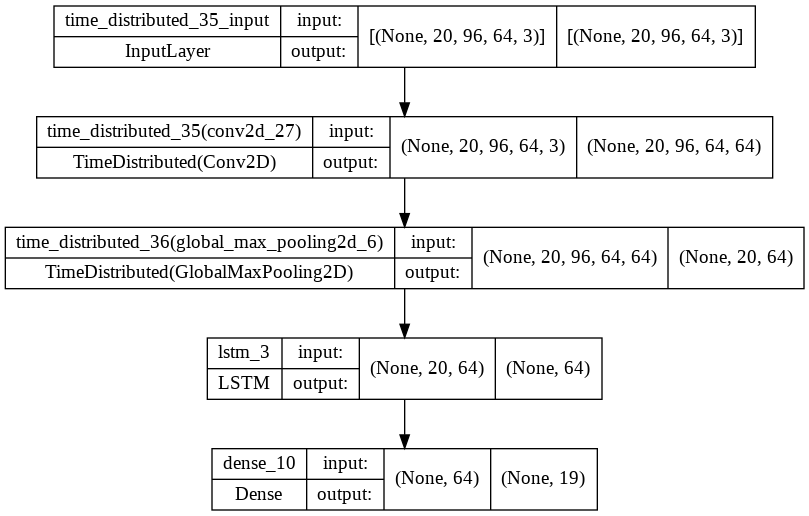

In [ ]:
# Si può inoltre stampare la struttura del modello

plot_model(LRCN_model_basic, to_file = 'LRCN_basic_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
## PARAMETRI E FITTING DEL MODELLO

# Si crea un parametro di Early Stopping, stoppando l'algoritmo quando la loss sul validation non decresce dopo più di 15 epoche 
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Si utilizza il comando compile per definire la metrica di loss, le metriche da ottimizzare e quale metodo applicare; in 
# questo caso si è scelto di utilizzare "Adam", ovvero lo stochastic gradient descent
LRCN_model_basic.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Definiti tutti i parametri d'interesse, si può iniziare ad allenare il modello sul set di training e valutare direttamente le
# performance sul validation dopo ogni epoca. Si inserisce inoltre lo *shuffle* per ridurre ulteriormente il bias durante 
# il training
LRCN_model_basic_training_history = LRCN_model_basic.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 64,
                                                         shuffle = True, callbacks = [early_stopping_callback], 
                                                         validation_data = (features_test, labels_test))

Epoch 1/150
36/36 [==============================] - 17s 416ms/step - loss: 2.8551 - accuracy: 0.1752 - val_loss: 2.8147 - val_accuracy: 0.1803
Epoch 2/150
36/36 [==============================] - 14s 399ms/step - loss: 2.8073 - accuracy: 0.1804 - val_loss: 2.7831 - val_accuracy: 0.1803
Epoch 3/150
36/36 [==============================] - 14s 407ms/step - loss: 2.7126 - accuracy: 0.1870 - val_loss: 2.6760 - val_accuracy: 0.1750
Epoch 4/150
36/36 [==============================] - 14s 398ms/step - loss: 2.6108 - accuracy: 0.1971 - val_loss: 2.6267 - val_accuracy: 0.1961
Epoch 5/150
36/36 [==============================] - 15s 424ms/step - loss: 2.5659 - accuracy: 0.2054 - val_loss: 2.5397 - val_accuracy: 0.2066
Epoch 6/150
36/36 [==============================] - 15s 410ms/step - loss: 2.5358 - accuracy: 0.2076 - val_loss: 2.5276 - val_accuracy: 0.2132
Epoch 7/150
36/36 [==============================] - 14s 404ms/step - loss: 2.5179 - accuracy: 0.2142 - val_loss: 2.5051 - val_accuracy:

In [ ]:
# Si riprendono le performance del miglior modello stimato

model_evaluation_history = LRCN_model_basic.evaluate(features_test, labels_test)

24/24 [==============================] - 1s 36ms/step - loss: 2.8053 - accuracy: 0.3895


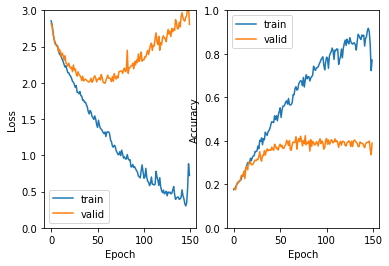

In [ ]:
## PLOT PER VISUALIZZARE L'ANDAMENTO DEL MODELLO IN BASE ALLE METRICHE D'INTERESSE

plt.subplot(1, 2, 1)
plt.plot(LRCN_model_basic_training_history.history['loss'])
plt.plot(LRCN_model_basic_training_history.history['val_loss'])
plt.ylim([0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LRCN_model_basic_training_history.history['accuracy'])
plt.plot(LRCN_model_basic_training_history.history['val_accuracy'])
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Le performance di questo modello decisamente basic non sono eccezionali ma era prevedibile. A fronte di un'accuracy tendenzialmente elevata sul training, corrisponde un valore di accuracy sul validation decisamente non adeguato con il rischio di overfitting. Si decide di definire un modello più complesso.

Una volta soddisfatti del modello, lo si può salvare.

In [ ]:
# from keras.models import load_model
LRCN_model_basic.save('/content/drive/MyDrive/Codice e Dataset/Modello_LRCN_basic/LRCN_basic_64_150_DEF.h5')

### Struttura del secondo modello

Il secondo  modello che si è deciso di definire è sicuramente più complesso: presenta un layer *Conv2D* a 64 filtri con *TimeDistributed*, seguito da un layer di *MaxPooling2D* e di *Dropout* con valore 0.25. Successivamente si inserisce un ulteriore layer *Conv2D* a 128 filtri seguito da *MaxPooling2D* e dallo strato di *Dropout*. Dopodiché si inserisce un ultimo strato di *Conv2D* a 256 filtri, seguito questa volta da un *GlobalMaxPooling2D*. 

A questo punto si è inserito un ultimo strato di *LSTM* con regolarizzatore Ridge e un numero di neuroni pari a 256. Infine, si ha un layer di *Flatten* e di *Dense* con funzione di attivazione softmax che, tramite una probabilità compresa tra 0 e 1, ci fornisce la previsione dell'azione compiuta all'interno del video.

In [ ]:
def create_LRCN_model():

    # Si inizializza un modello di tipo sequenziale
    model = Sequential()
    
    # Primo strato di Conv2D con 64 filtri di dimensioni 4x4 con opzione Dropout per rendere indipendenti i neuroni con un tasso
    # del 30%, con funzione di attivazione 'relu' e strato di MaxPooling2D
    model.add(TimeDistributed(Conv2D(64, (4, 4), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(TimeDistributed(MaxPooling2D((4,4)))) 
    model.add(TimeDistributed(Dropout(0.3)))
    
    # Secondo strato di Conv2D con 128 filtri di dimensioni 4x4 con opzione Dropout per rendere indipendenti i neuroni con un tasso
    # del 30%, con funzione di attivazione 'relu' e strato di MaxPooling2D
    model.add(TimeDistributed(Conv2D(128, (4, 4), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    # Terzo strato di Conv2D con 256 filtri di dimensioni 2x2 con opzione Dropout per rendere indipendenti i neuroni con un tasso
    # del 30%, con funzione di attivazione 'relu' e strato di GlobalMaxPooling2D 
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(GlobalMaxPooling2D()))

    # Ultimo strato di LSTM con 256 neuroni, regolarizzatore mediante Ridge e funzione di attivazione 'relu'
    model.add(LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.1)))
   
    # Layer di Flatten 
    model.add(Flatten())

    # Infine strato di Dense con funzione di attivazione 'softmax' per ridurre l'output al numero di categorie pari a 19                                  
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax')) #kernel_regularizer='l1_l2',

    model.summary()
    
    return model

In [ ]:
# Si applica la funzione per generare il modello

LRCN_model = create_LRCN_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 20, 96, 64, 64)   3136      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 24, 16, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 24, 16, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 24, 16, 128)  131200    
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 6, 4, 128)   

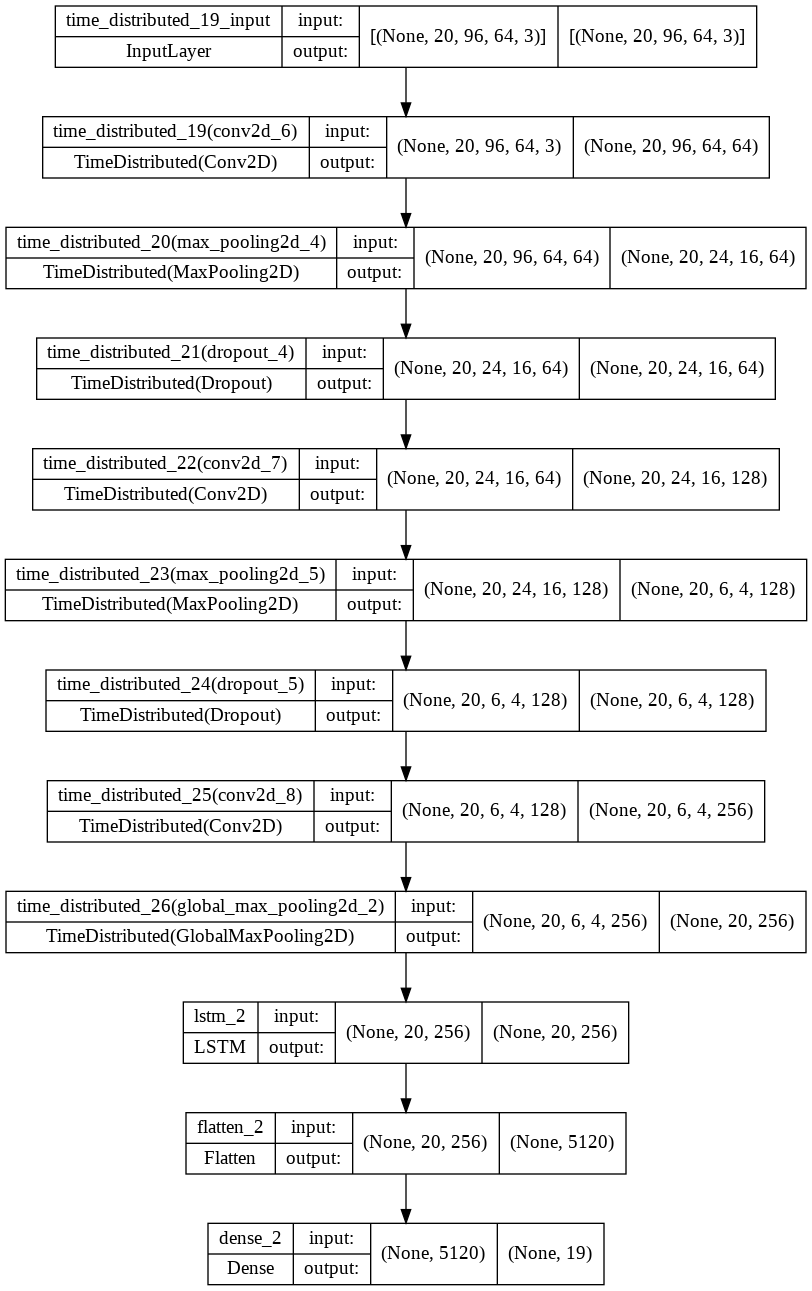

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
## PARAMETRI E FITTING DEL MODELLO

# Si crea un parametro di Early Stopping, stoppando l'algoritmo quando la loss sul validation non decresce dopo più di 10 epoche 
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min', restore_best_weights = True)

# Si utilizza il comando compile per definire la metrica di loss, le metriche da ottimizzare e quale metodo applicare; in 
# questo caso si è scelto di utilizzare "Adam", ovvero lo stochastic gradient descent
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Definiti tutti i parametri d'interesse, si può iniziare ad allenare il modello sul set di training e valutare direttamente le
# performance sul validation dopo ogni epoca. Si inserisce inoltre lo *shuffle* per ridurre ulteriormente il bias durante 
# il training
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 32,
                                             shuffle = True, callbacks = [early_stopping_callback], 
                                             validation_data = (features_test, labels_test))

Epoch 1/150
72/72 [==============================] - 34s 256ms/step - loss: 13.8876 - accuracy: 0.1752 - val_loss: 3.0564 - val_accuracy: 0.1961
Epoch 2/150
72/72 [==============================] - 13s 182ms/step - loss: 2.7307 - accuracy: 0.1848 - val_loss: 2.6273 - val_accuracy: 0.1987
Epoch 3/150
72/72 [==============================] - 17s 237ms/step - loss: 2.5673 - accuracy: 0.1958 - val_loss: 2.7675 - val_accuracy: 0.1763
Epoch 4/150
72/72 [==============================] - 14s 190ms/step - loss: 2.5665 - accuracy: 0.2037 - val_loss: 2.5509 - val_accuracy: 0.2026
Epoch 5/150
72/72 [==============================] - 15s 208ms/step - loss: 2.5147 - accuracy: 0.2024 - val_loss: 2.5116 - val_accuracy: 0.2132
Epoch 6/150
72/72 [==============================] - 16s 221ms/step - loss: 2.4866 - accuracy: 0.2147 - val_loss: 2.4840 - val_accuracy: 0.2224
Epoch 7/150
72/72 [==============================] - 14s 191ms/step - loss: 2.4502 - accuracy: 0.2160 - val_loss: 2.6199 - val_accuracy

In [ ]:
# In questo modo si riprende il miglior modello trovato

model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

24/24 [==============================] - 1s 41ms/step - loss: 4.2734 - accuracy: 0.4118


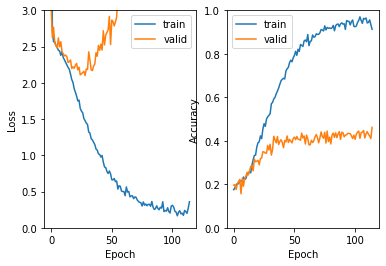

In [ ]:
## PLOT PER VISUALIZZARE L'ANDAMENTO DEL MODELLO IN BASE ALLE METRICHE D'INTERESSE

plt.subplot(1, 2, 1)
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.ylim([0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Anche in questo caso i risultati non sono assolutamente soddisfacenti: a seguito di un'elevato valore di accuracy sul training, si ha un valore della metrica sostanzialmente costante pari a 0.4 sul validation. Si è in presenza di un'eccessiva specializzazione del modello sui dati di training. Si valuta e si decide di applicare un diverso approccio nel trattare questa tipologia di dati: l'approccio MoveNet.

In [ ]:
# from keras.models import load_model
# LRCN_model = load_model('/content/drive/MyDrive/Codice e Dataset/Modello_LRCN/LRCN_Batch_Global_Bidirectional_Flatten.h5')
LRCN_model.save('/content/drive/MyDrive/Codice e Dataset/Modello_LRCN/LRCN_Conv_LSTM_64_DEF.h5')